This notebook is used for creating a matrix of trajecotry start positions for use in Lagranto.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import csv
from wrf import *
from netCDF4 import Dataset
from lagranto import Tra
import glob
import cartopy.crs as ccrs
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection

In [10]:
#latitude of bottom left corner of the matrix
start_lat = 47.0
#longitude of bottom left corner of the matrix
start_lon = -122.8
#WRF output file for the desired start time
wrfout = Dataset("/home/getker/lagranto/wrfout_d01_2021-06-28_21:00:00", "r", format="NETCDF4")

In [11]:
#Get some variables from the WRF output file--land mask, terrain height, theta
lsm = wrfout['LANDMASK'][0]
top = wrfout['HGT'][0]
theta_arr = getvar(wrfout, 'theta')
lats, lons = latlon_coords(pot_temp)
ht = getvar(wrfout, "z", units="m",  msl = False)

#make a grid of x and y grid points based on the shape of the output variable
x_pts = np.linspace(0, lsm.shape[0], lsm.shape[0])
y_pts = np.linspace(0, lsm.shape[1], lsm.shape[1])

#Find the grid cell which corresponds to your start coordinate
xy_pt = ll_to_xy(wrfout, start_lat, start_lon)
start_x = xy_pt.values[0]
start_y = xy_pt.values[1]

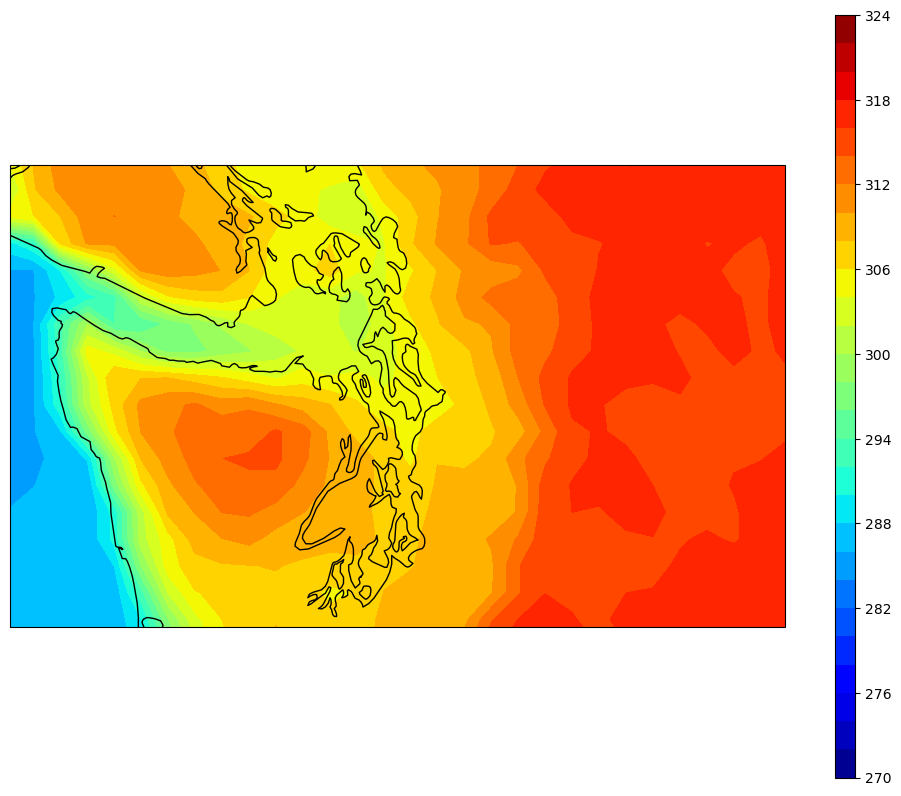

In [12]:
"""
Plotting near surface potential temperature to check my start theta values look correct
"""
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = ccrs.Mercator())
ax.coastlines()
cs = ax.contourf(lons, lats, theta_arr[1,:,:], transform = ccrs.PlateCarree(), levels = 30, cmap = 'jet')
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])  #You can change the numbers to move the colorbar.
cbar = plt.colorbar(cs, cax = cax)
ax.set_extent([-125, -120, 47, 49], crs=ccrs.PlateCarree())


In [13]:
"""
In this cell, I loop over a given area to get a matrix of start positions.
"""
height_interval = 20 #trajectory start height intervals
min_theta= 308 #Only including parcels with theta greater than 308 K
lats_start = []  #trajectory start latitudes
lons_start = [] #trajectory start longitudes
z_list = [] #trajectory start heights (m)
thetas = [] #theta values at each starting location
coords_list = [] #trajectory start positions in x, y, z
for i in range(4):
    for j in range(8):
        for k in range(20):
            lev = interplevel(theta_arr, ht, height_interval * k)
            theta = lev[start_y + j, start_x + i].values
            if theta > min_theta:
                thetas.append(theta)
                lats_start.append(lats[start_y + j][0].values)
                lons_start.append(lons[0][start_x + i].values)
                z_list.append(height_interval*k)
                coords_list.append([start_x + i, start_y + j, 10 * k])
print(coords_list)

[[298, 221, 180], [298, 221, 190], [298, 222, 20], [298, 222, 30], [298, 222, 40], [298, 222, 50], [298, 222, 60], [298, 222, 70], [298, 222, 80], [298, 222, 90], [298, 222, 100], [298, 222, 110], [298, 222, 120], [298, 222, 130], [298, 222, 140], [298, 222, 150], [298, 222, 160], [298, 222, 170], [298, 222, 180], [298, 222, 190], [298, 223, 20], [298, 223, 30], [298, 223, 40], [298, 223, 50], [298, 223, 60], [298, 223, 70], [298, 223, 80], [298, 223, 90], [298, 223, 100], [298, 223, 110], [298, 223, 120], [298, 223, 130], [298, 223, 140], [298, 223, 150], [298, 223, 160], [298, 223, 170], [298, 223, 180], [298, 223, 190], [298, 224, 20], [298, 224, 30], [298, 224, 40], [298, 224, 50], [298, 224, 60], [298, 224, 70], [298, 224, 80], [298, 224, 90], [298, 224, 100], [298, 224, 110], [298, 224, 120], [298, 224, 130], [298, 224, 140], [298, 224, 150], [298, 224, 160], [298, 224, 170], [298, 224, 180], [298, 224, 190], [298, 225, 20], [298, 225, 30], [298, 225, 40], [298, 225, 50], [298, 2

(array([83., 70., 48., 79., 19.]),
 array([308.00463867, 308.36401367, 308.72335815, 309.08273315,
        309.44207764, 309.80145264]),
 <BarContainer object of 5 artists>)

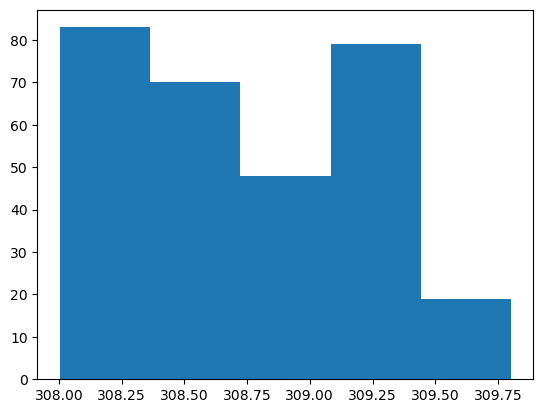

In [14]:
"""
Plotting a histogram of start position theta values
"""
plt.hist(thetas, bins = 5)

In [15]:
"""
print(lats_start[0])

new_lons = []
new_lats = []
for i in range(len(lons_start)):
    new_lons.append(lons_start[i].values)
    new_lats.append(lats_start[i].values)
"""

'\nprint(lats_start[0])\n\nnew_lons = []\nnew_lats = []\nfor i in range(len(lons_start)):\n    new_lons.append(lons_start[i].values)\n    new_lats.append(lats_start[i].values)\n'

In [16]:
"""
Getting the inner domain to plot its coastlines and terrain, subsetting over the Washington area
"""
wrfout = Dataset("/home/getker/lagranto/wrfout_d02_2021-06-22_00:00:00", "r", format="NETCDF4") 
lsm = getvar(wrfout, 'LANDMASK')
top = getvar(wrfout, 'HGT')
lats, lons = latlon_coords(lsm)

elon = -120
wlon = -126
nlon = 49
slon = 46

lats = lats.where((lats['XLAT'] < nlon) & (lats['XLAT'] > slon) & (lats['XLONG'] < elon) & (lats['XLONG'] > wlon), drop = True)
lons = lons.where((lons['XLONG'] > wlon) & (lons['XLONG'] < elon) &(lons['XLAT'] < nlon) & (lons['XLAT'] > slon), drop = True)
lsm = lsm.where((lsm['XLONG'] > wlon) & (lsm['XLONG'] < elon) & (lsm['XLAT'] < nlon) & (lsm['XLAT'] > slon), drop = True)
top = top.where((top['XLONG'] > wlon) & (top['XLONG'] < elon) & (top['XLAT'] < nlon) & (top['XLAT'] > slon), drop = True)
print(lsm)

<xarray.DataArray 'LANDMASK' (south_north: 76, west_east: 103)>
array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -126.0 -125.9 ... -120.1 -120.0
    XLAT     (south_north, west_east) float32 46.04 46.04 46.04 ... 48.97 48.97
    XTIME    float32 0.0
    Time     datetime64[ns] 2021-06-22
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  LAND MASK (1 FOR LAND, 0 FOR WATER)
    units:        
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   Mercator(stand_lon=-9.404999732971191, moad_cen_lat=51.6179...


/tmp/ipykernel_613/3386191266.py:6: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 100


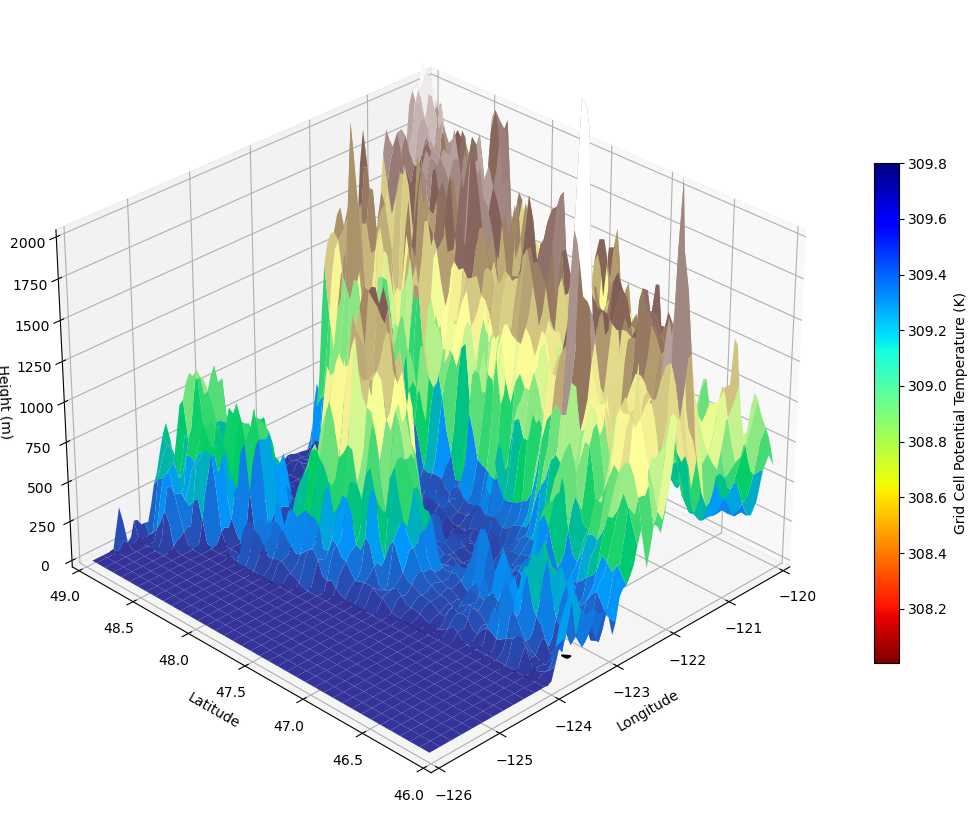

In [18]:
"""
Plotting the start positions and WRF terrain in 3D
"""
fig = plt.figure(figsize = (13,13))
ax = fig.add_subplot(projection='3d')
ax.dist = 100
ax.plot_surface(lons, lats, top, cmap = 'terrain', alpha = .5) #plot topography
ax.contour3D(lons, lats, lsm, colors = 'black', levels = 0) #plot land mask
cs = ax.scatter3D(lons_start, lats_start, z_list, c = thetas, cmap = 'jet_r') #plot start position, color coded by theta
cbar = plt.colorbar(cs, ax=ax, shrink=0.5)
cbar.set_label("Grid Cell Potential Temperature (K)")
ax.set_xlim(wlon, elon)
ax.set_ylim(slon, nlon)
ax.set_zlim(0, 2000)
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
ax.set_zlabel("Height (m)")
ax.view_init(30,-135)

In [ ]:
"""
Write out the grid points in the format Lagranto expects for starting positions
"""
with open("startf.xy", 'w') as csvfile:
     csvwriter = csv.writer(csvfile)
     for i in range(len(coords_list)):
          csvwriter.writerow([str(coords_list[i][0]) + "   " + str(coords_list[i][1]) + "   " + str(z_list[i])]) 